In [101]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Crear una sesión de Spark
spark = SparkSession.builder.appName("CargarDatosLimpios").getOrCreate()

# Ruta donde se guardó el DataFrame
ruta_guardado = "/home/jovyan/work/datos_asturias_limpio_7.csv"

# Leer el archivo CSV guardado
df = spark.read.csv(ruta_guardado, header=True, inferSchema=True)

In [103]:
# Mostrar el esquema y algunas filas para verificar
df.printSchema()
df.show(5)

root
 |-- fecha: date (nullable = true)
 |-- tmed: double (nullable = true)
 |-- tmin: double (nullable = true)
 |-- tmax: double (nullable = true)
 |-- hrMedia: double (nullable = true)

+----------+----+----+----+-------+
|     fecha|tmed|tmin|tmax|hrMedia|
+----------+----+----+----+-------+
|2019-01-01| 5.7| 1.5| 9.9|   90.0|
|2019-01-02| 7.9| 6.0| 9.8|   76.0|
|2019-01-03| 6.1| 1.7|10.5|   77.0|
|2019-01-04| 4.9|-1.4|11.2|   75.0|
|2019-01-05| 6.1| 0.0|12.2|   74.0|
+----------+----+----+----+-------+
only showing top 5 rows



In [104]:
df = df.toPandas()
df_pandas = df.copy()

In [105]:
df_pandas.isna().sum()

fecha      0
tmed       8
tmin       8
tmax       8
hrMedia    4
dtype: int64

In [106]:
df.head(5)

,fecha,tmed,tmin,tmax,hrMedia
0,2019-01-01,5.7,1.5,9.9,90.0
1,2019-01-02,7.9,6.0,9.8,76.0
2,2019-01-03,6.1,1.7,10.5,77.0
3,2019-01-04,4.9,-1.4,11.2,75.0
4,2019-01-05,6.1,0.0,12.2,74.0


In [107]:
# Convertir la columna 'fecha' a tipo datetime
df['fecha'] = pd.to_datetime(df['fecha'])

# Ordenar por fecha
df = df.sort_values('fecha')

# Verificar que no haya duplicados
df = df.drop_duplicates(subset=['fecha'])

In [108]:
# Crear columnas de estadísticas históricas
df['tmed_max'] = df.groupby(df['fecha'].dt.dayofyear)['tmed'].transform('max')
df['tmed_min'] = df.groupby(df['fecha'].dt.dayofyear)['tmed'].transform('min')
df['tmed_mean'] = df.groupby(df['fecha'].dt.dayofyear)['tmed'].transform('mean')

In [109]:
# Crear columna estación del año
def get_season(month):
    if month in [12, 1, 2]:
        return 'Invierno'
    elif month in [3, 4, 5]:
        return 'Primavera'
    elif month in [6, 7, 8]:
        return 'Verano'
    elif month in [9, 10, 11]:
        return 'Otoño'

In [110]:
df['estacion'] = df['fecha'].dt.month.apply(get_season)

In [111]:
# Aplicar get_dummies
df = pd.get_dummies(df, columns=['estacion'])

In [112]:
# Crear columnas de día de la semana y mes
df['dia_semana'] = df['fecha'].dt.dayofweek
df['mes'] = df['fecha'].dt.month

In [113]:
# Crear columnas de diferencias y variaciones
df['tmed_diff'] = df['tmed'].diff()
df['tmed_rolling_mean'] = df['tmed'].rolling(window=7).mean()

In [114]:
df.head(15)

,fecha,tmed,tmin,tmax,hrMedia,tmed_max,tmed_min,tmed_mean,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano,dia_semana,mes,tmed_diff,tmed_rolling_mean
0,2019-01-01,5.7,1.5,9.9,90.0,17.7,5.7,9.928571,True,False,False,False,1,1,NaN,NaN
1,2019-01-02,7.9,6.0,9.8,76.0,16.2,4.6,10.342857,True,False,False,False,2,1,2.2,NaN
2,2019-01-03,6.1,1.7,10.5,77.0,14.8,5.3,10.485714,True,False,False,False,3,1,-1.8,NaN
3,2019-01-04,4.9,-1.4,11.2,75.0,15.3,3.6,9.971429,True,False,False,False,4,1,-1.2,NaN
4,2019-01-05,6.1,0.0,12.2,74.0,15.8,4.8,8.914286,True,False,False,False,5,1,1.2,NaN
5,2019-01-06,5.0,-1.0,11.0,81.0,11.0,5.0,8.085714,True,False,False,False,6,1,-1.1,NaN
6,2019-01-07,4.9,-0.2,10.0,76.0,13.6,4.4,8.600000,True,False,False,False,0,1,-0.1,5.800000
7,2019-01-08,6.2,0.9,11.6,79.0,15.6,3.5,9.528571,True,False,False,False,1,1,1.3,5.871429
8,2019-01-09,7.6,5.1,10.2,88.0,14.4,3.3,9.928571,True,False,False,False,2,1,1.4,5.828571
9,2019-01-10,6.0,2.2,9.9,77.0,15.6,6.0,9.771429,True,False,False,False,3,1,-1.6,5.814286


In [115]:
# Seleccionar columnas relevantes
df_model = df[['fecha', 'tmed', 'tmed_max', 'tmed_min', 'tmed_mean', 'estacion_Invierno', 'estacion_Otoño', 'estacion_Primavera', 
               'estacion_Verano', 'dia_semana', 'mes', 'tmed_diff', 'tmed_rolling_mean']]

# Asegurarse de que no haya valores nulos en las columnas relevantes
df_model = df_model.dropna(subset=['fecha', 'tmed', 'tmed_max', 'tmed_min', 'tmed_mean', 'estacion_Invierno', 'estacion_Otoño', 
                                   'estacion_Primavera', 'estacion_Verano', 'dia_semana', 'mes', 'tmed_diff', 'tmed_rolling_mean'])

In [116]:
df_model.head(5)

,fecha,tmed,tmed_max,tmed_min,tmed_mean,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano,dia_semana,mes,tmed_diff,tmed_rolling_mean
6,2019-01-07,4.9,13.6,4.4,8.600000,True,False,False,False,0,1,-0.1,5.800000
7,2019-01-08,6.2,15.6,3.5,9.528571,True,False,False,False,1,1,1.3,5.871429
8,2019-01-09,7.6,14.4,3.3,9.928571,True,False,False,False,2,1,1.4,5.828571
9,2019-01-10,6.0,15.6,6.0,9.771429,True,False,False,False,3,1,-1.6,5.814286
10,2019-01-11,4.8,11.8,4.8,8.242857,True,False,False,False,4,1,-1.2,5.800000


In [117]:
df_model.reset_index(inplace=True)
df_model.drop(columns=["index"], inplace=True)

In [118]:
!pip install skforecast

In [119]:
from skforecast.preprocessing import RollingFeatures

In [120]:
# Configurar características de ventana
rolling = RollingFeatures(
    stats=['mean', 'std', 'min', 'max'],  # Estadísticas a calcular
    window_sizes=[7, 7, 7, 7]            # Tamaño de la ventana para cada estadística
)

In [121]:
!pip install lightgbm

In [122]:
from skforecast.recursive import ForecasterRecursive
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

In [123]:
# Dividir los datos en entrenamiento y prueba
train_size = int(len(df_model) * 0.8)
train = df_model.iloc[:train_size]
test = df_model.iloc[train_size:]

In [124]:
# Crear y entrenar el modelo
forecaster = ForecasterRecursive(
    regressor=LGBMRegressor(random_state=123, verbose=-1),  # Usar LightGBM como regresor
    lags=10,                                               # Usar los últimos 10 días como lags
    window_features=rolling                                # Incluir características de ventana
)

In [125]:
# Ajustar el modelo
forecaster.fit(
    y=train['tmed'],  # Variable objetivo
    exog=train[['tmed_max', 'tmed_min', 'tmed_mean', 'estacion_Invierno', 'estacion_Otoño', 'estacion_Primavera', 'estacion_Verano', 
                'dia_semana', 'mes']]  # Características exógenas
)

/opt/conda/lib/python3.12/site-packages/skforecast/utils/utils.py:561: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=DataTypeWarning)
  warnings.warn(


In [126]:
# Realizar predicciones
predictions = forecaster.predict(
    steps=len(test),
    exog=test[['tmed_max', 'tmed_min', 'tmed_mean', 'estacion_Invierno', 'estacion_Otoño', 'estacion_Primavera', 'estacion_Verano', 
                'dia_semana', 'mes']]  # Características exógenas para la predicción
)

/opt/conda/lib/python3.12/site-packages/skforecast/utils/utils.py:561: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=DataTypeWarning)
  warnings.warn(


In [127]:
# Calcular el MSE
mse = mean_squared_error(test['tmed'], predictions)
print(f'Error Cuadrático Medio (MSE): {mse}')
# Calcular el RMSE
rmse = np.sqrt(mse)
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse}')
# Calcular el MAPE
mape = mean_absolute_percentage_error(test['tmed'], predictions)
print(f'Error Porcentual Absoluto Medio (MAPE): {mape}')

Error Cuadrático Medio (MSE): 8.675648558190096
Raíz del Error Cuadrático Medio (RMSE): 2.9454453921589
Error Porcentual Absoluto Medio (MAPE): 0.18180138130511203


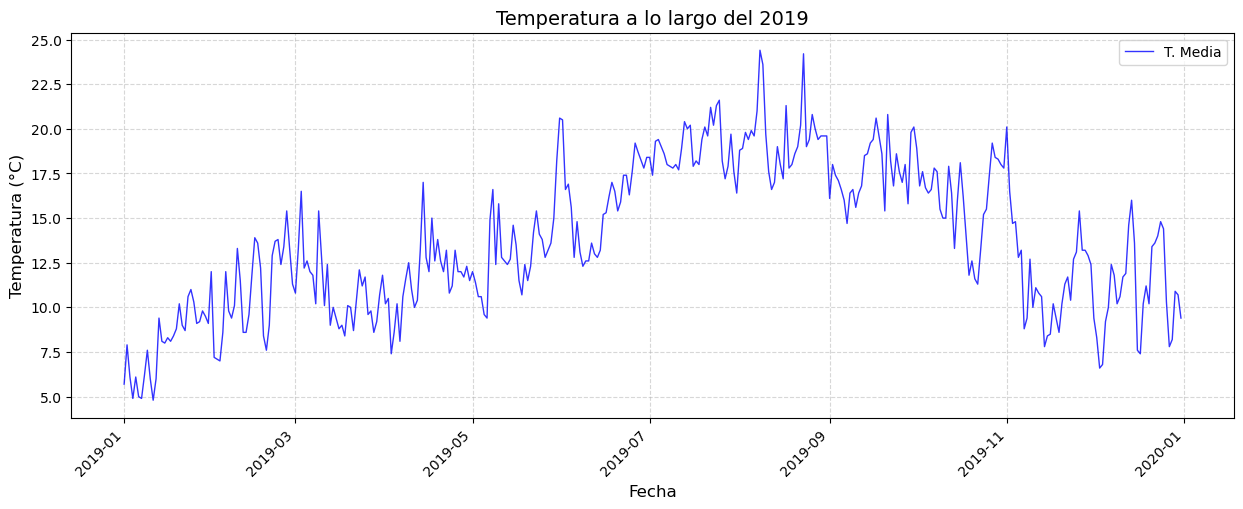

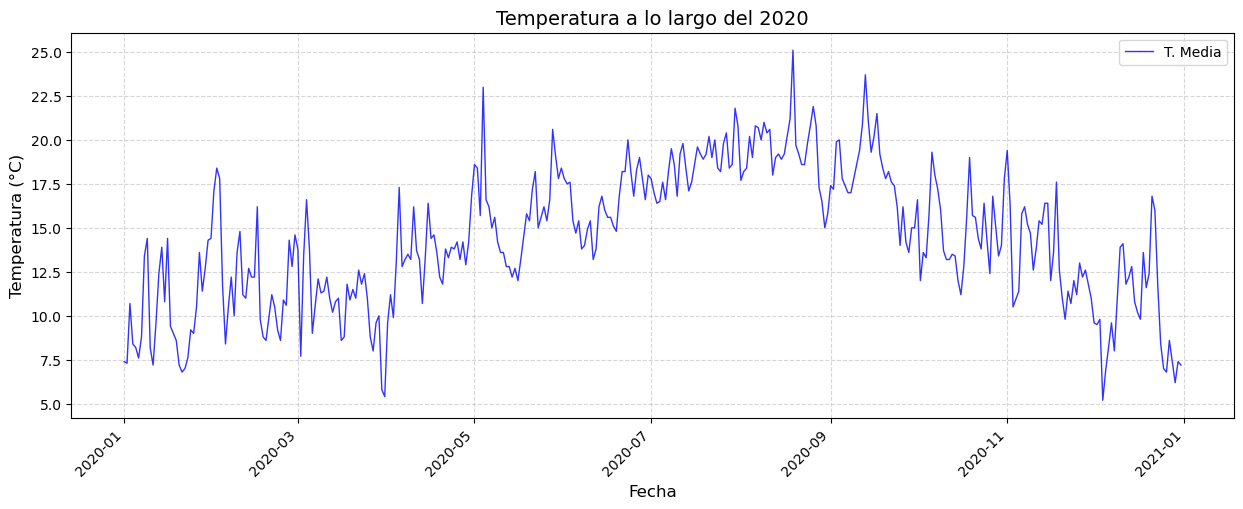

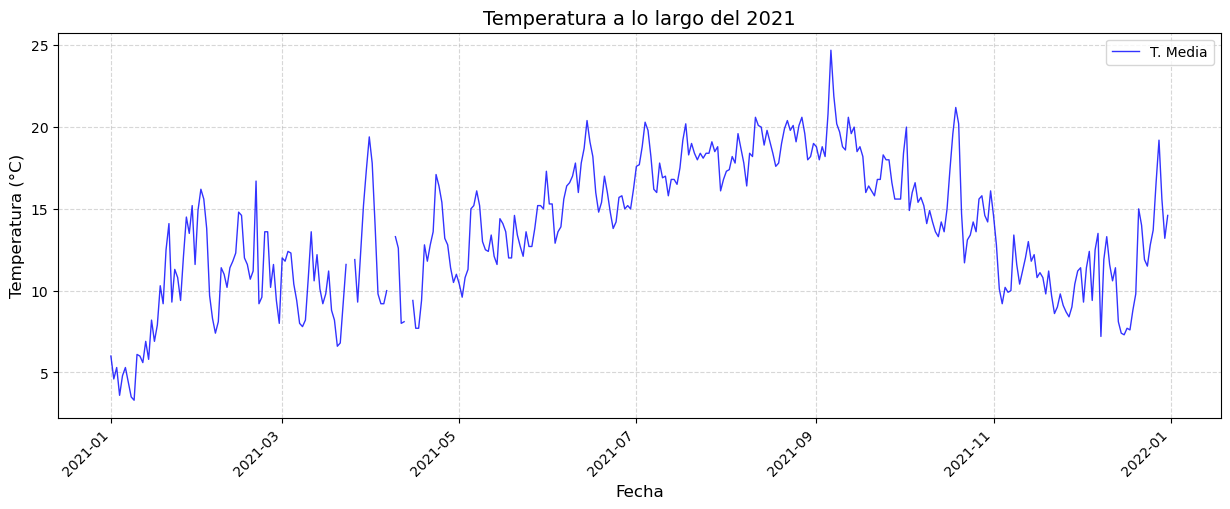

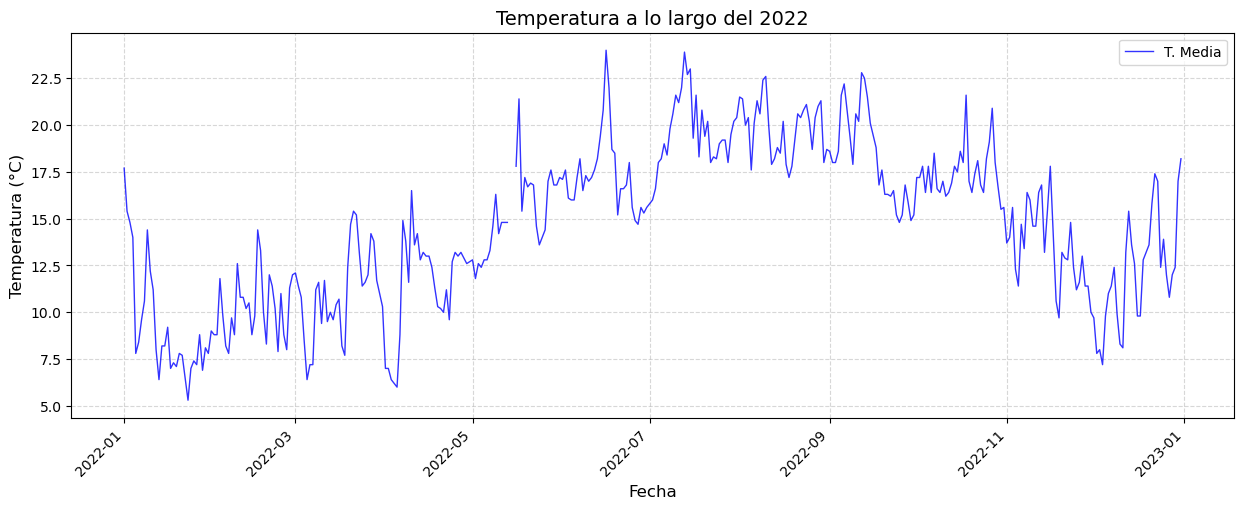

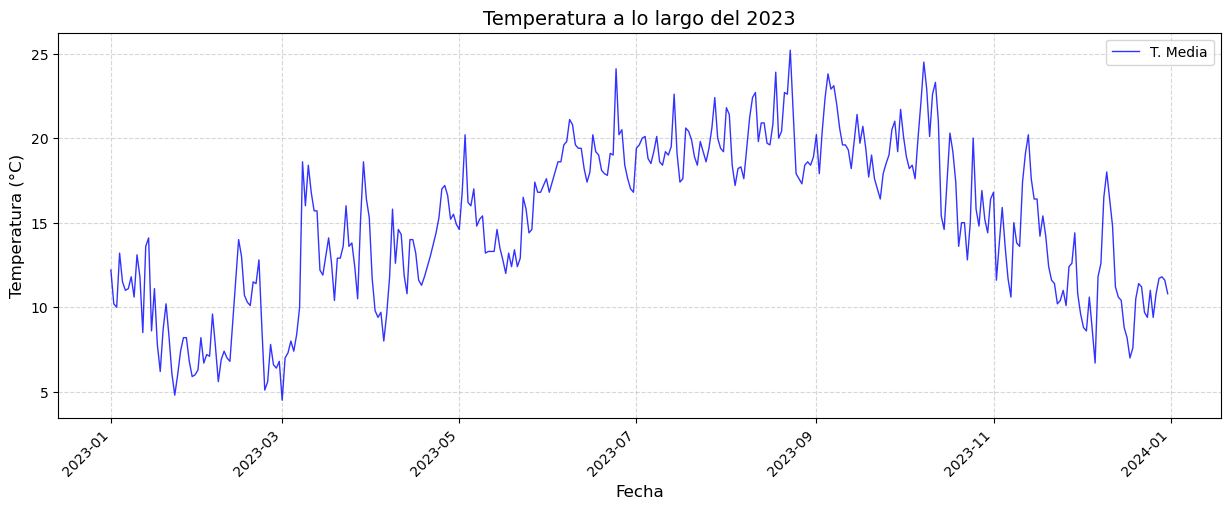

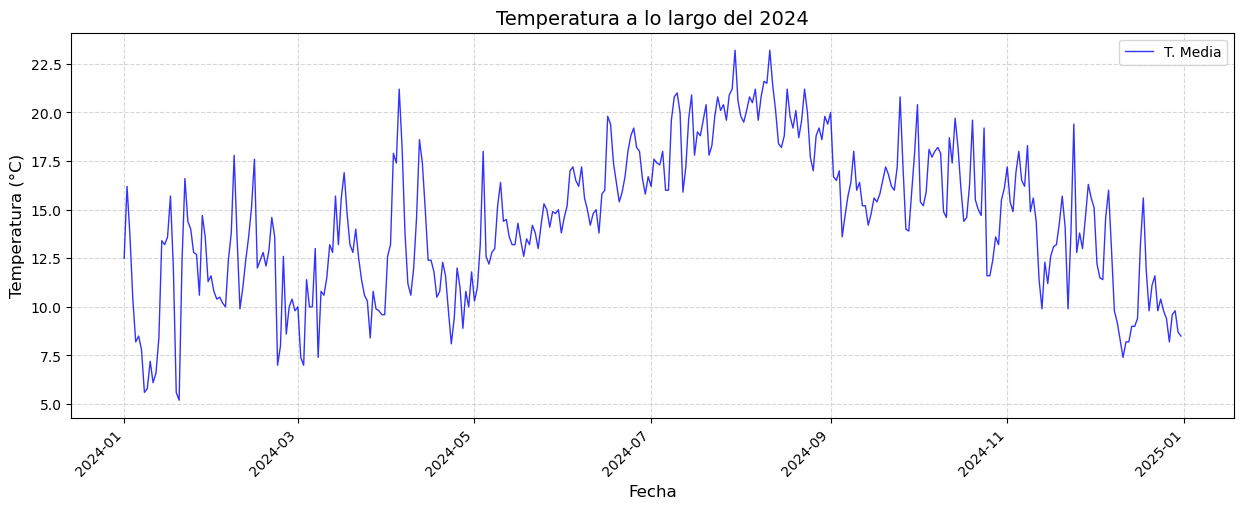

In [128]:
# Convertir la columna 'fecha' a tipo datetime si no lo está
df_pandas['fecha'] = pd.to_datetime(df_pandas['fecha'])

# Ordenar el DataFrame por fecha
df_pandas = df_pandas.sort_values(by='fecha')

# Obtener los años únicos en el DataFrame
años_unicos = df_pandas['fecha'].dt.year.unique()

# Generar un gráfico por cada año
for año in años_unicos[:6]:
    df_anual = df_pandas[df_pandas['fecha'].dt.year == año]
    
    plt.figure(figsize=(15, 5))
    plt.plot(df_anual['fecha'], df_anual['tmed'], linestyle='-', color='b', linewidth=1, alpha=0.8, label='T. Media')
    
    # Etiquetas y título
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Temperatura (°C)', fontsize=12)
    plt.title(f'Temperatura a lo largo del {año}', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45, ha='right')

    # Mostrar el gráfico
    plt.show()

In [129]:
# Seleccionar las características exógenas para los últimos 7 días
exog_future = test[['tmed_max', 'tmed_min', 'tmed_mean', 'estacion_Invierno', 'estacion_Otoño', 
                    'estacion_Primavera', 'estacion_Verano', 'dia_semana', 'mes']].iloc[:7]
# Realizar predicciones para los próximos 7 días
predictions = forecaster.predict(steps=7, exog=exog_future)

/opt/conda/lib/python3.12/site-packages/skforecast/utils/utils.py:561: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=DataTypeWarning)
  warnings.warn(


In [130]:
predictions

1758    13.446307
1759    12.181613
1760    10.030663
1761     9.115058
1762     9.302056
1763     9.147181
1764     9.076791
Name: pred, dtype: float64

In [132]:
df_pandas["tmed"] = df_pandas["tmed"].interpolate(method="linear")


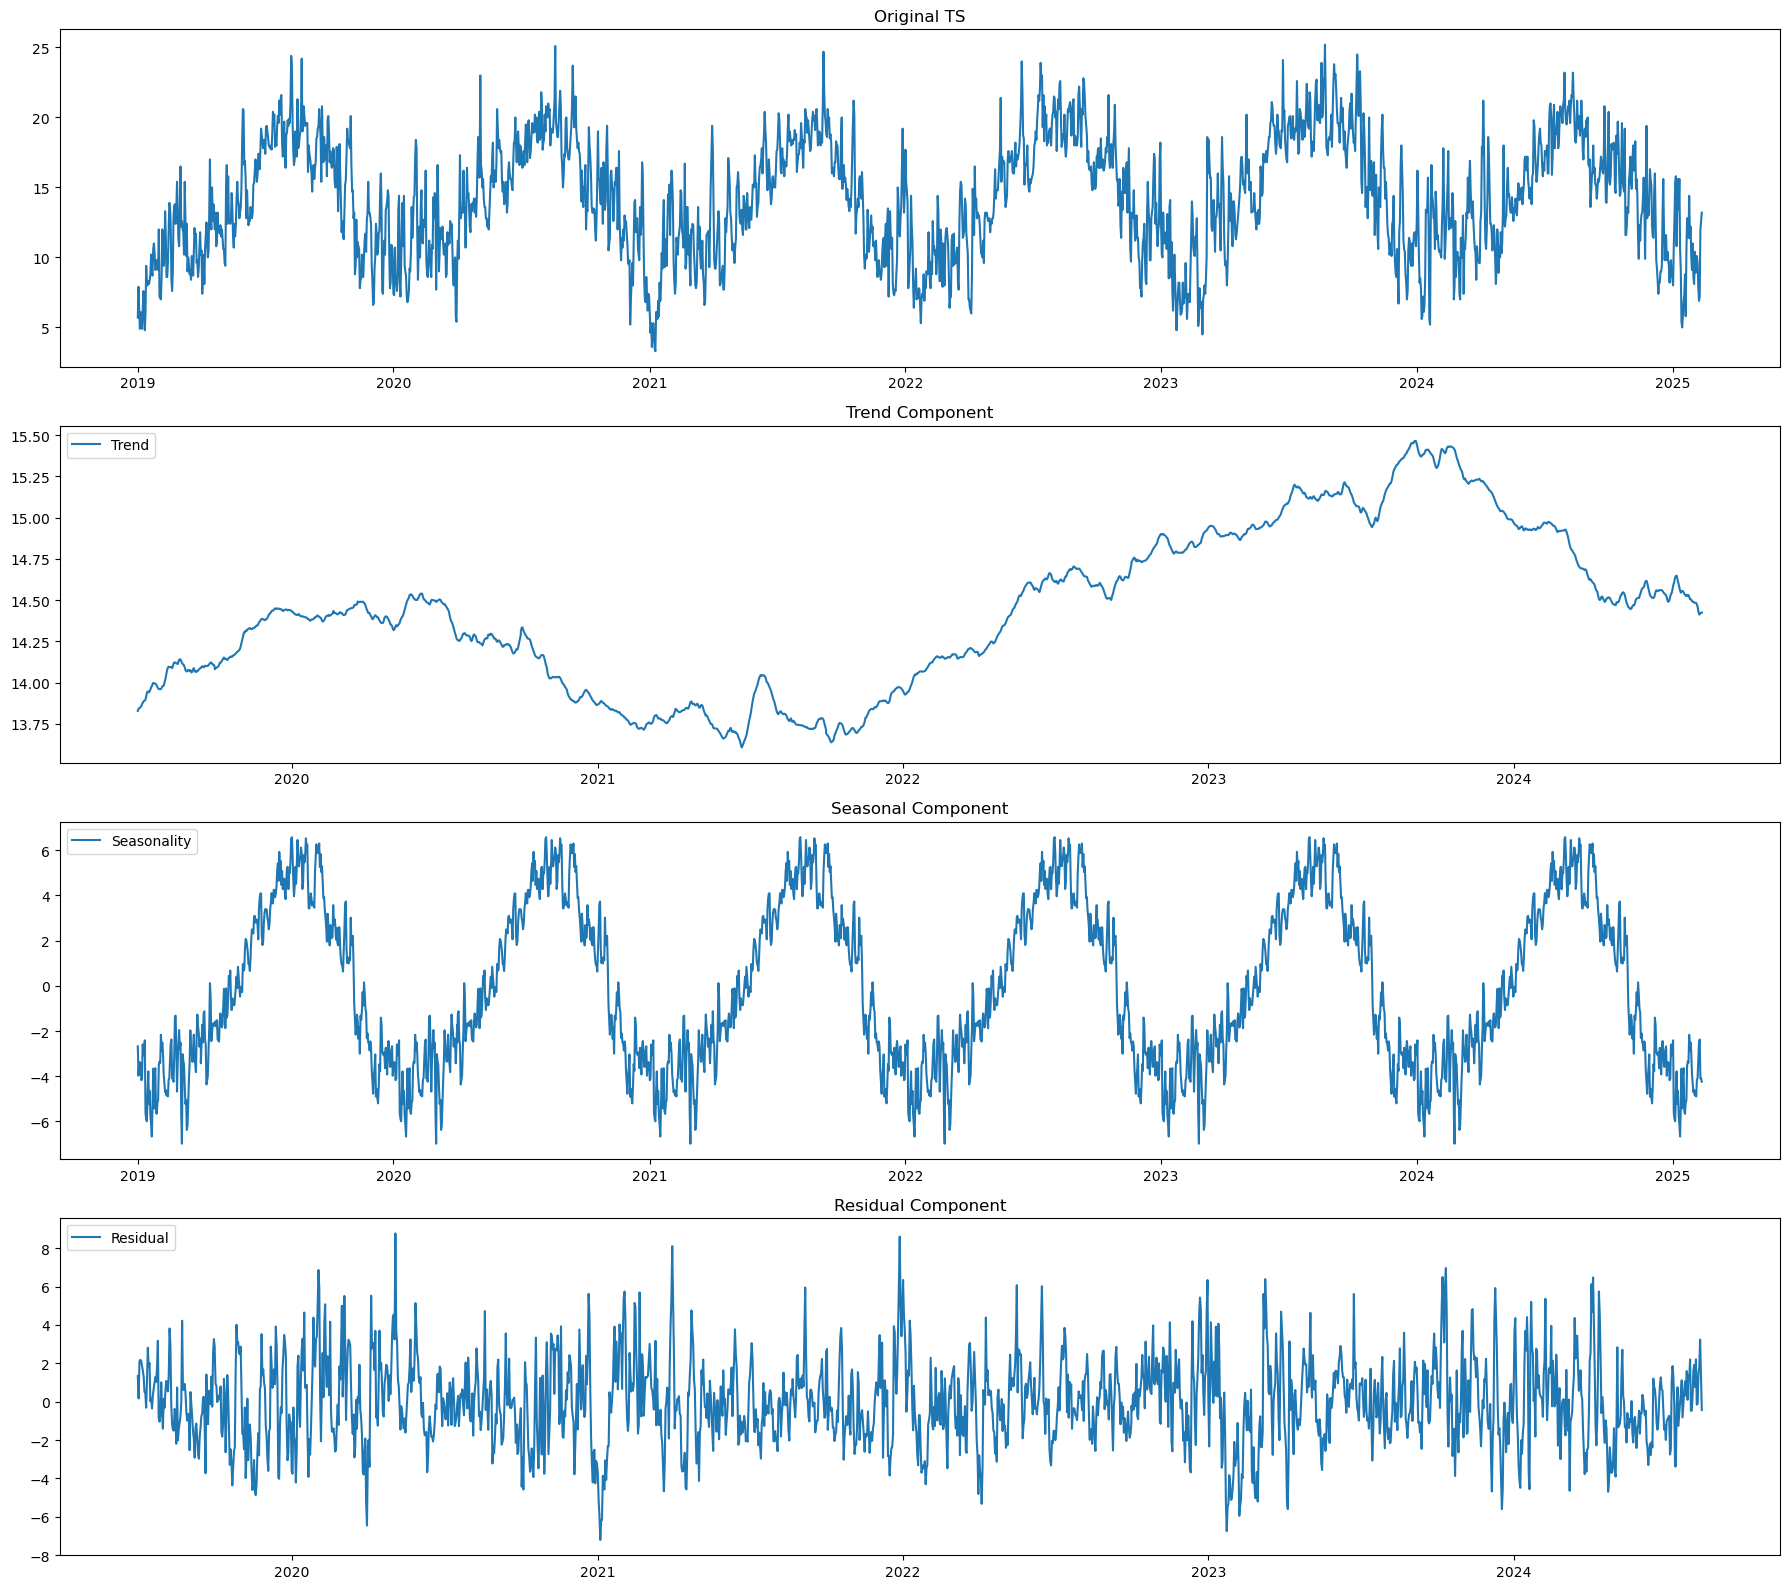

In [133]:
decomposition_air = seasonal_decompose(df_pandas['tmed'], model='additive', period=365)

# Plot the decomposed components for Air Passengers
plt.figure(figsize=(18, 16))

plt.subplot(4, 1, 1)
plt.plot(df_pandas["fecha"], df_pandas["tmed"])
plt.title('Original TS')

plt.subplot(4, 1, 2)
plt.plot(df_pandas["fecha"], decomposition_air.trend, label='Trend')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(df_pandas["fecha"], decomposition_air.seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(df_pandas["fecha"], decomposition_air.resid, label='Residual')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

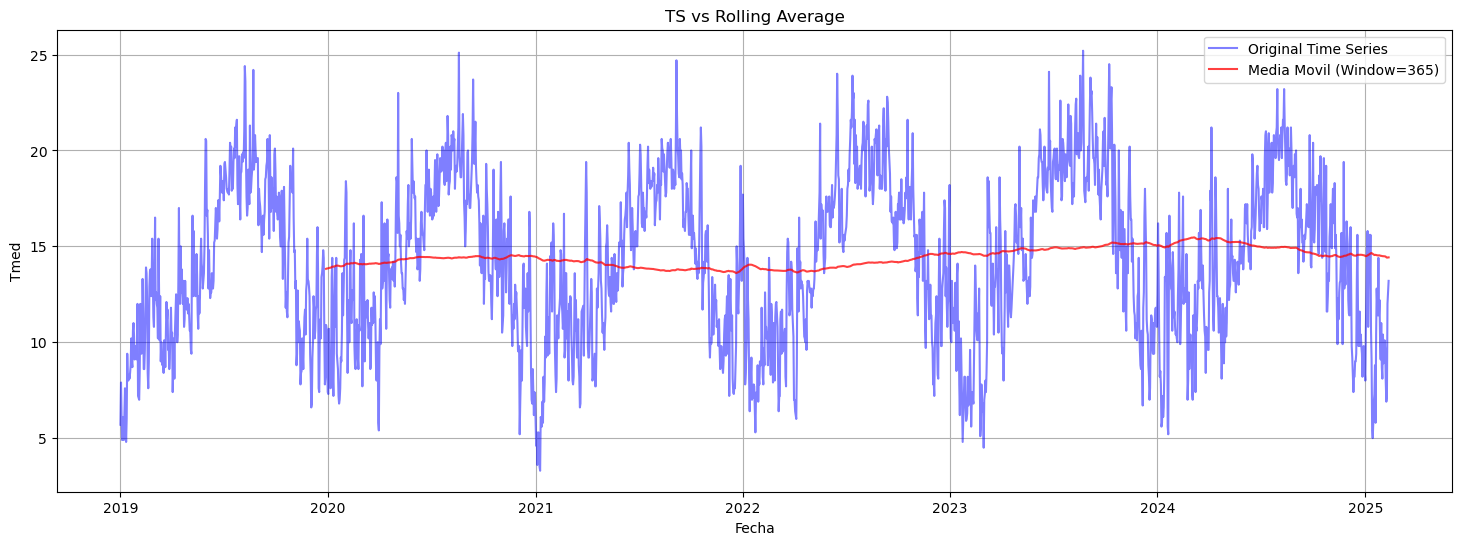

In [134]:
window_size = 365

df_pandas['MA'] = df_pandas["tmed"].rolling(window=window_size).mean()

plt.figure(figsize=(18, 6))

plt.plot(df_pandas["fecha"], df_pandas['tmed'], label='Original Time Series', color='blue', alpha=0.5)
plt.plot(df_pandas["fecha"], df_pandas['MA'], label=f'Media Movil (Window={window_size})', color='red', alpha=0.75)

plt.title('TS vs Rolling Average')
plt.xlabel('Fecha')
plt.ylabel('Tmed')
plt.legend()
plt.grid(True)
plt.show()

In [137]:
df = df.dropna(subset=['tmed'])


In [138]:
df['tmed'] = df['tmed'].interpolate(method='linear')  # Interpolación lineal

In [139]:
def check_stationarity(series, name):
    result = adfuller(series)
    print(f'ADF Statistic for {name}:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("La serie es estacionaria.")
    else:
        print("La serie no es estacionaria.")

In [140]:
check_stationarity(df['tmed'], 'T. media')

ADF Statistic for T. media: -3.689360747687224
p-value: 0.004265318051940745
La serie es estacionaria.


In [141]:
from scipy.stats import median_abs_deviation

In [142]:
window = 30  # 30 days window
threshold = 2  # Threshold of 2 standard deviations

ma = df_pandas["tmed"].rolling(window=window, center=True).mean()
std = df_pandas["tmed"].rolling(window=window, center=True).std()

#Treshold min and max
threshold_min = ma - std*threshold 
threshold_max = ma + std*threshold 

#Outliers detection
df_pandas["outlier_ma"] = (np.abs(df_pandas["tmed"] - ma) > threshold * std)

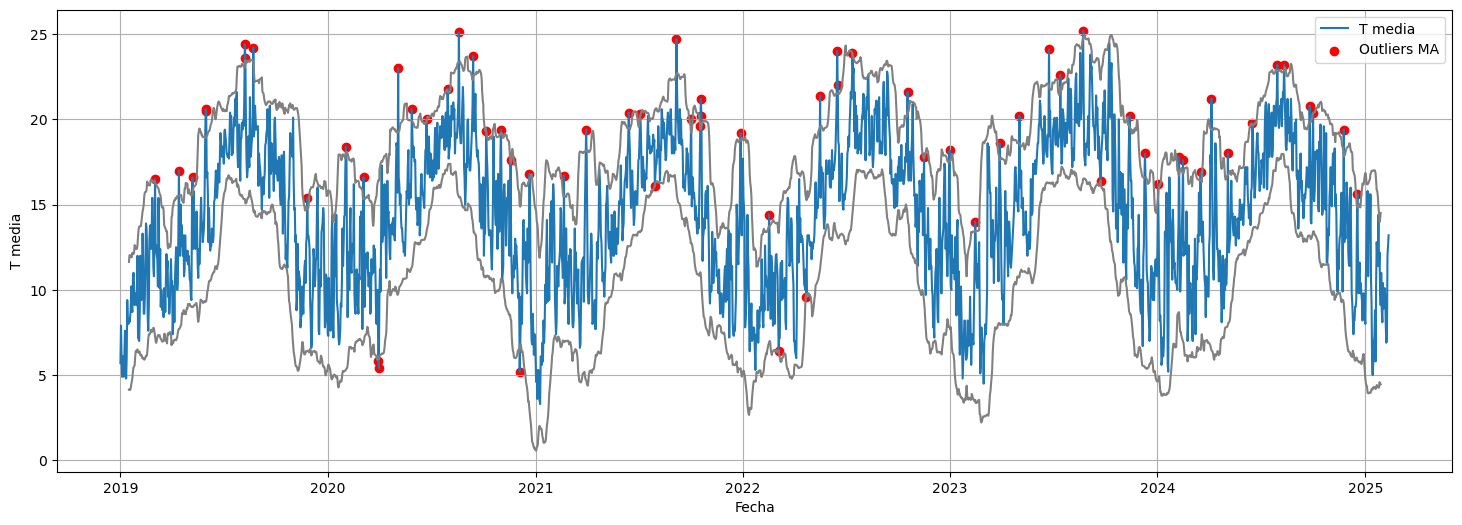

In [143]:
plt.figure(figsize=(18, 6))

plt.plot(df_pandas['fecha'], df_pandas['tmed'], label='T media')
plt.plot(df_pandas['fecha'], threshold_min, color='gray')
plt.plot(df_pandas['fecha'], threshold_max, color='gray')

plt.scatter(df_pandas["fecha"][df_pandas["outlier_ma"]], df_pandas["tmed"][df_pandas["outlier_ma"]], color='red', label="Outliers MA")
plt.xlabel('Fecha')
plt.ylabel('T media')
plt.legend()
plt.grid(True)
plt.show()

In [146]:
window_size=30
n_sigma=3

#Calculate the median in a rolling centered window
rolling_median = df_pandas["tmed"].rolling(window_size, center=True).median()

#Calculate the median of the absolute deviations from the data’s median in a rolling centered window
mad = df_pandas["tmed"].rolling(window_size, center=True).apply(median_abs_deviation)

#Treshold 
threshold_min = rolling_median - n_sigma*mad
threshold_max = rolling_median + n_sigma*mad

df_pandas["outlier_hm"] = (np.abs(df_pandas["tmed"] - rolling_median) > n_sigma*mad)

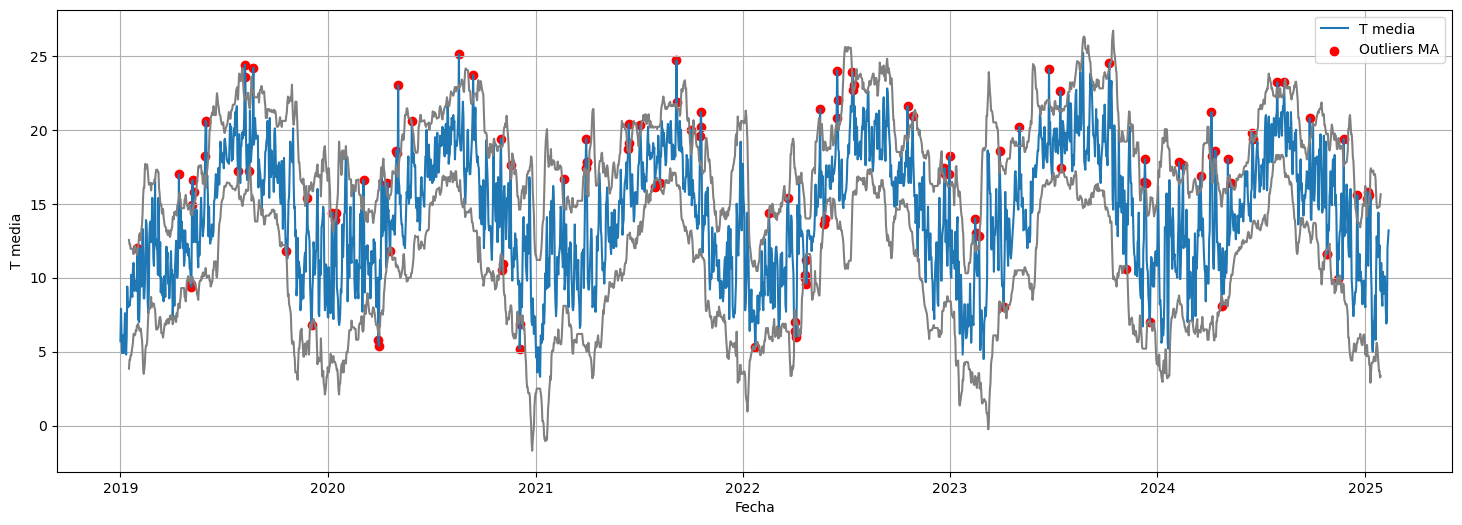

In [147]:
plt.figure(figsize=(18, 6))

plt.plot(df_pandas['fecha'], df_pandas['tmed'], label='T media')
plt.plot(df_pandas['fecha'], threshold_min, color='gray')
plt.plot(df_pandas['fecha'], threshold_max, color='gray')
plt.scatter(df_pandas["fecha"][df_pandas["outlier_hm"]], df_pandas["tmed"][df_pandas["outlier_hm"]], color='red', label="Outliers MA")
plt.xlabel('Fecha')
plt.ylabel('T media')
plt.legend()
plt.grid(True)
plt.show()

In [148]:
df_pandas[df_pandas["outlier_hm"]==True].head()

,fecha,tmed,tmin,tmax,hrMedia,MA,outlier_ma,outlier_hm
30,2019-01-31,12.0,8.7,15.2,84.0,NaN,False,True
104,2019-04-14,17.0,13.1,21.0,70.0,NaN,True,True
125,2019-05-05,9.6,5.5,13.7,57.0,NaN,False,True
126,2019-05-06,9.4,4.1,14.8,81.0,NaN,False,True
127,2019-05-07,14.9,10.5,19.3,73.0,NaN,False,True


In [149]:
# Sustituir los outliers por el valor más cercano dentro del rango
df_pandas["tmed_corrected"] = df_pandas["tmed"].copy()
df_pandas.loc[df_pandas["tmed"] < threshold_min, "tmed_corrected"] = threshold_min
df_pandas.loc[df_pandas["tmed"] > threshold_max, "tmed_corrected"] = threshold_max

In [150]:
df_pandas[df_pandas["outlier_hm"]==True].head()

,fecha,tmed,tmin,tmax,hrMedia,MA,outlier_ma,outlier_hm,tmed_corrected
30,2019-01-31,12.0,8.7,15.2,84.0,NaN,False,True,11.85
104,2019-04-14,17.0,13.1,21.0,70.0,NaN,True,True,15.35
125,2019-05-05,9.6,5.5,13.7,57.0,NaN,False,True,10.05
126,2019-05-06,9.4,4.1,14.8,81.0,NaN,False,True,9.75
127,2019-05-07,14.9,10.5,19.3,73.0,NaN,False,True,14.25


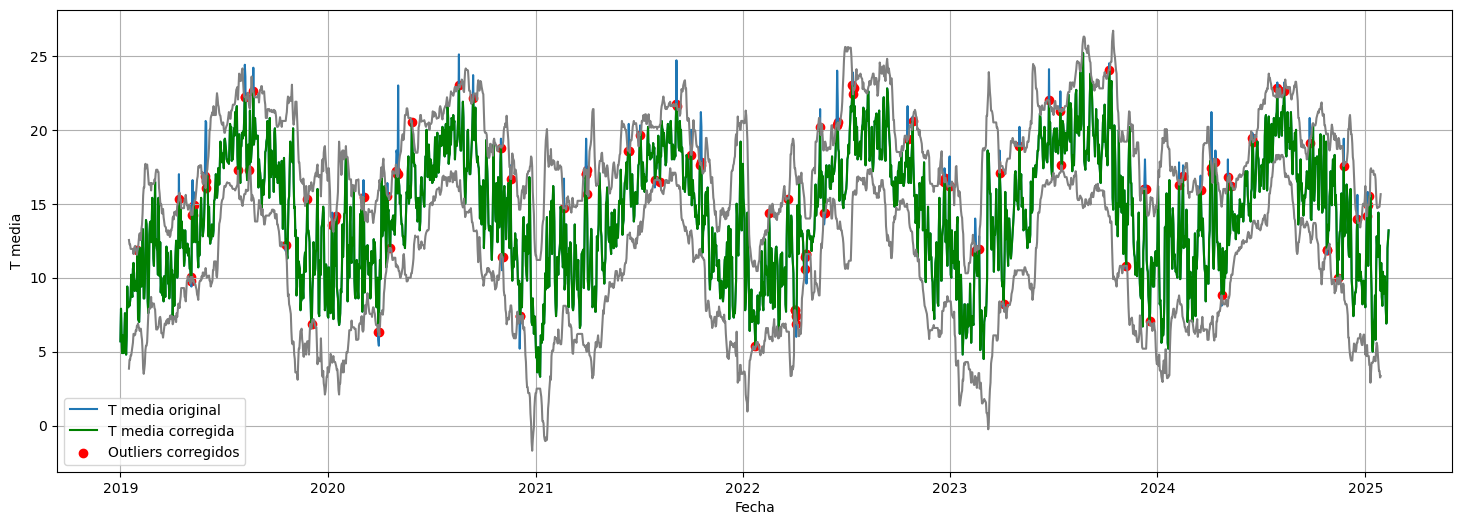

In [151]:
# Graficar los resultados
plt.figure(figsize=(18, 6))

plt.plot(df_pandas['fecha'], df_pandas['tmed'], label='T media original')
plt.plot(df_pandas['fecha'], df_pandas['tmed_corrected'], label='T media corregida', color='green')
plt.plot(df_pandas['fecha'], threshold_min, color='gray')
plt.plot(df_pandas['fecha'], threshold_max, color='gray')
plt.scatter(df_pandas["fecha"][df_pandas["outlier_hm"]], df_pandas["tmed_corrected"][df_pandas["outlier_hm"]], color='red', label="Outliers corregidos")
plt.xlabel('Fecha')
plt.ylabel('T media')
plt.legend()
plt.grid(True)
plt.show()

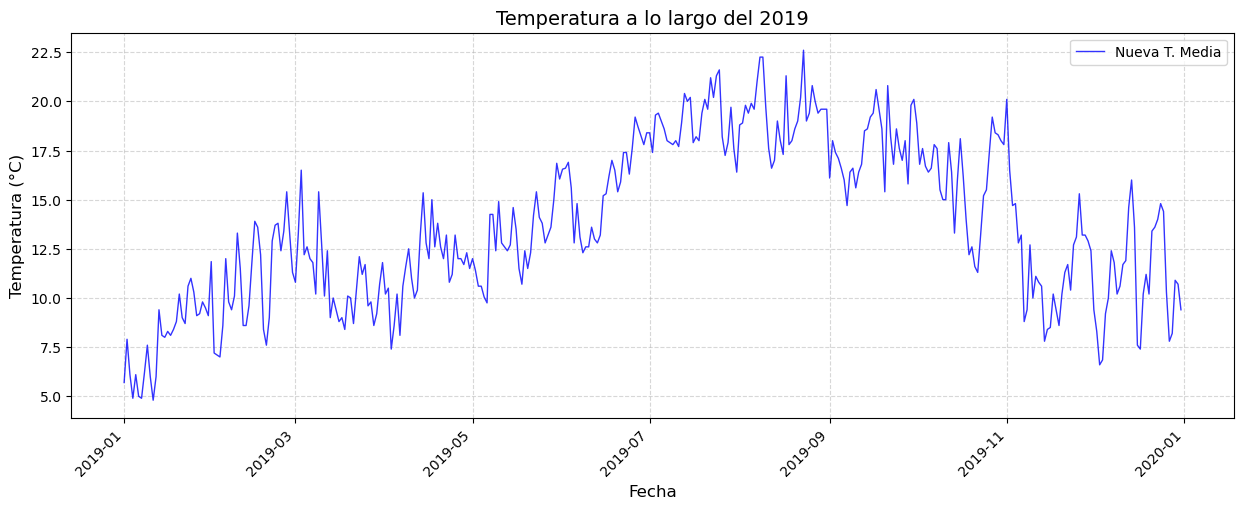

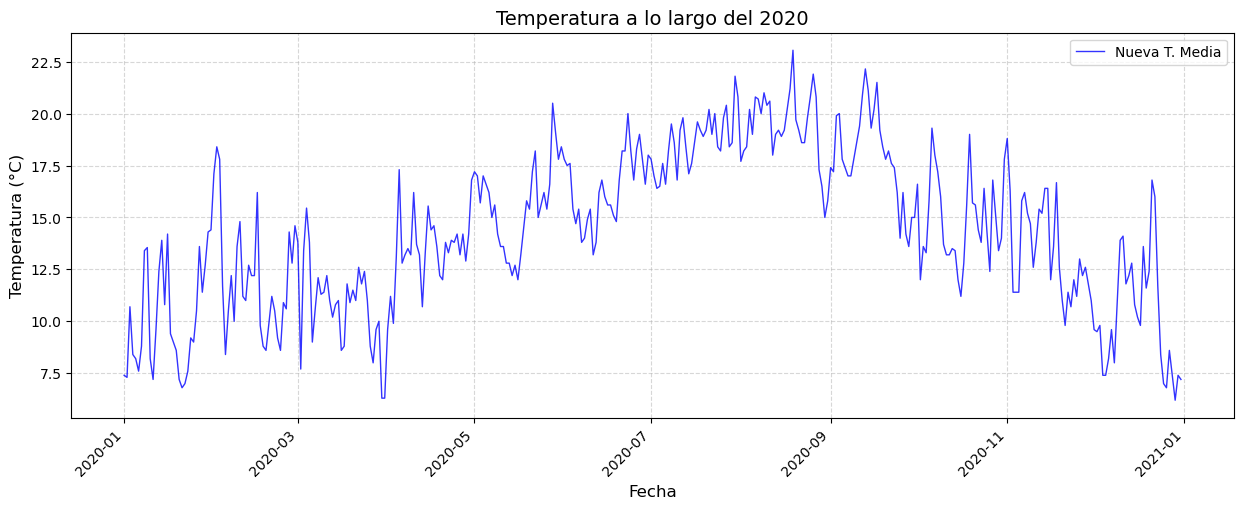

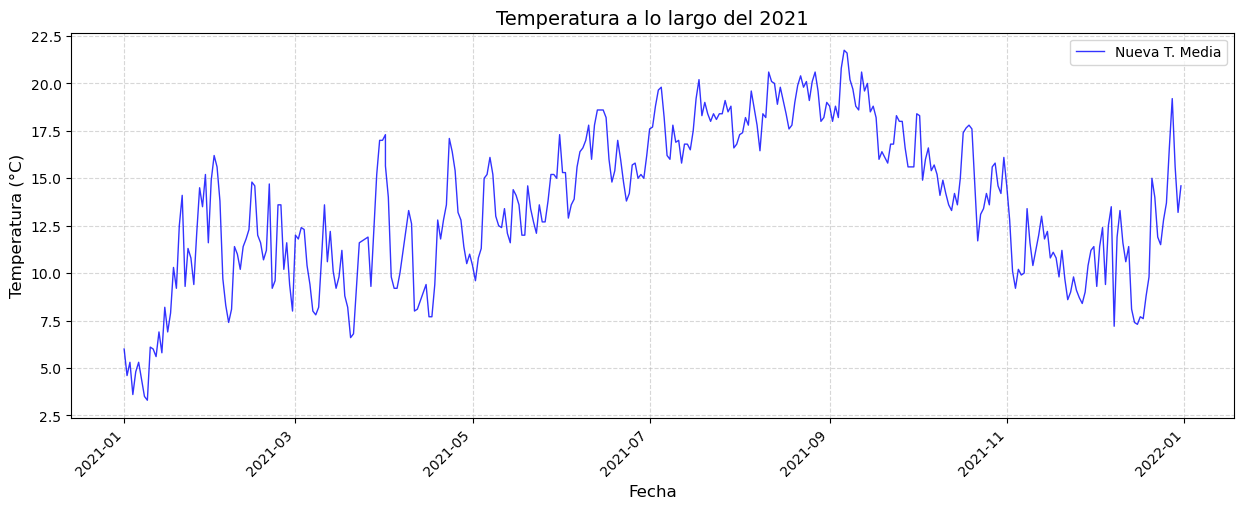

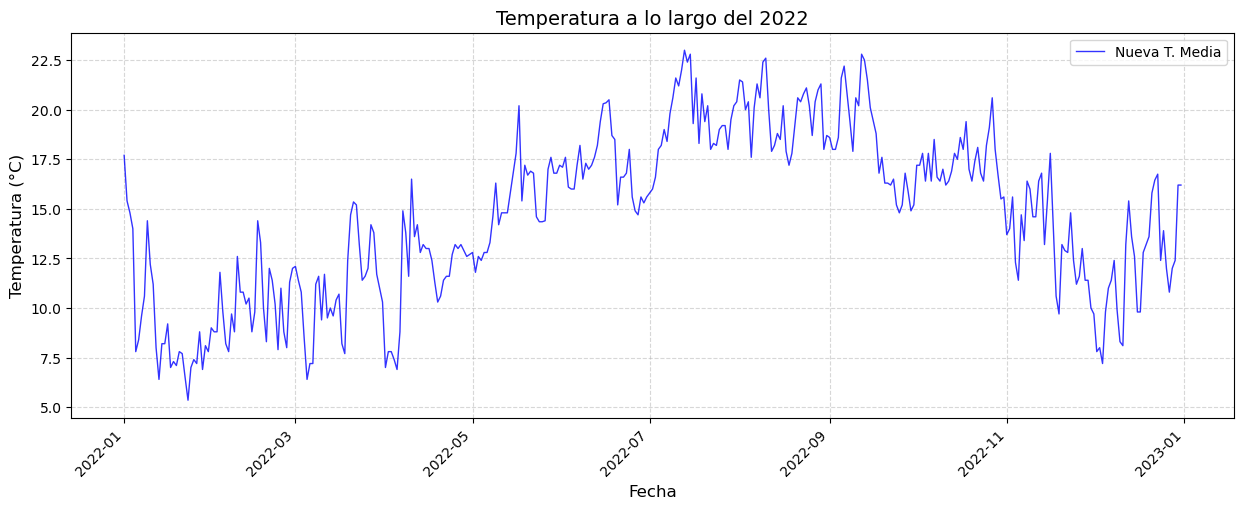

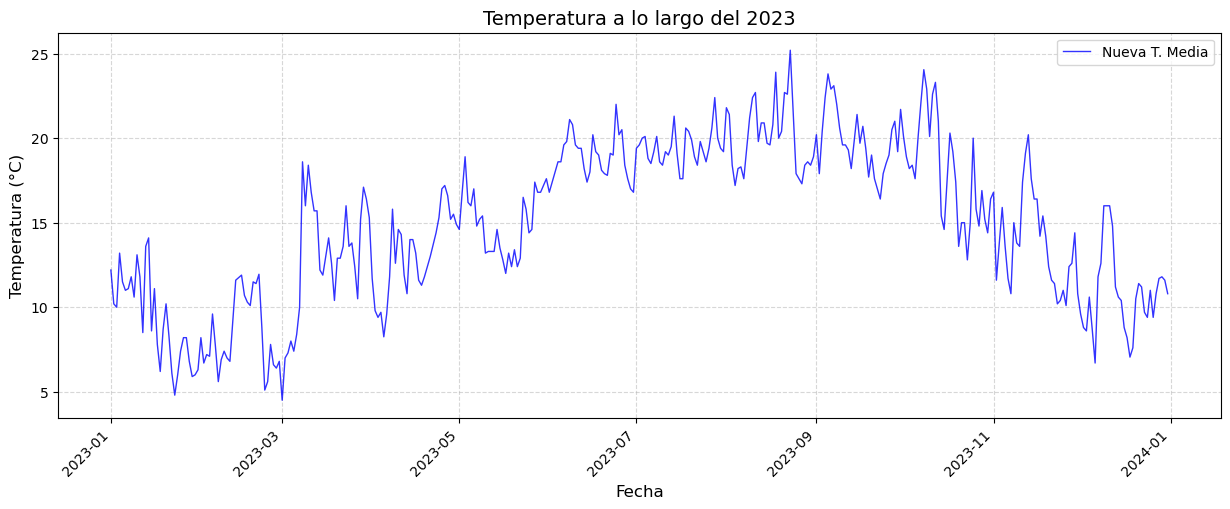

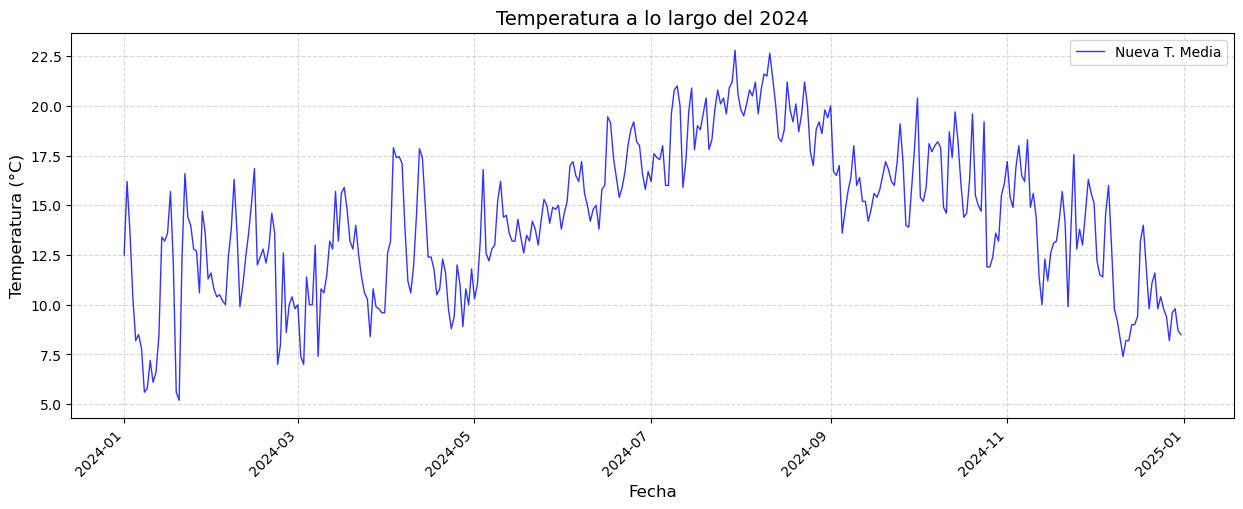

In [152]:
# Obtener los años únicos en el DataFrame
años_unicos = df_pandas['fecha'].dt.year.unique()

# Generar un gráfico por cada año
for año in años_unicos[:6]:
    df_anual = df_pandas[df_pandas['fecha'].dt.year == año]
    
    plt.figure(figsize=(15, 5))
    plt.plot(df_anual['fecha'], df_anual['tmed_corrected'], linestyle='-', color='b', linewidth=1, alpha=0.8, label='Nueva T. Media')
    
    # Etiquetas y título
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Temperatura (°C)', fontsize=12)
    plt.title(f'Temperatura a lo largo del {año}', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45, ha='right')

    # Mostrar el gráfico
    plt.show()

In [153]:
df = df_pandas.copy()

In [154]:
# Convertir la columna 'fecha' a tipo datetime
df['fecha'] = pd.to_datetime(df['fecha'])

# Ordenar por fecha
df = df.sort_values('fecha')

# Verificar que no haya duplicados
df = df.drop_duplicates(subset=['fecha'])

In [155]:
# Crear columnas de estadísticas históricas
def calcular_estadisticas_diarias(df, columna):
    # Verifica si la columna existe en el DataFrame
    if columna not in df.columns:
        raise ValueError(f"La columna '{columna}' no existe en el DataFrame.")

    # Calcula el máximo, mínimo y media diaria
    df[f'{columna}_max'] = df.groupby(df['fecha'].dt.dayofyear)[columna].transform('max')
    df[f'{columna}_min'] = df.groupby(df['fecha'].dt.dayofyear)[columna].transform('min')
    df[f'{columna}_mean'] = df.groupby(df['fecha'].dt.dayofyear)[columna].transform('mean')

    return df

In [156]:
# Lista de columnas para las cuales se calcularán las estadísticas
columnas = ['tmed', 'tmin', 'tmax', 'hrMedia']

# Bucle para aplicar la función a cada columna
for columna in columnas:
    df = calcular_estadisticas_diarias(df, columna)

In [157]:
# Crear columna de estación del año
def get_season(month):
    if month in [12, 1, 2]:
        return 'Invierno'
    elif month in [3, 4, 5]:
        return 'Primavera'
    elif month in [6, 7, 8]:
        return 'Verano'
    elif month in [9, 10, 11]:
        return 'Otoño'

In [158]:
df['estacion'] = df['fecha'].dt.month.apply(get_season)

In [159]:
# Aplicar get_dummies
df = pd.get_dummies(df, columns=['estacion'])

In [160]:
# Crear columnas de día de la semana y mes
# df['dia_semana'] = df['fecha'].dt.dayofweek
df['mes'] = df['fecha'].dt.month

In [161]:
df.head(5)

,fecha,tmed,tmin,tmax,hrMedia,MA,outlier_ma,outlier_hm,tmed_corrected,tmed_max,...,tmax_min,tmax_mean,hrMedia_max,hrMedia_min,hrMedia_mean,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano,mes
0,2019-01-01,5.7,1.5,9.9,90.0,NaN,False,False,5.7,17.7,...,8.5,13.385714,93.0,46.0,75.142857,True,False,False,False,1
1,2019-01-02,7.9,6.0,9.8,76.0,NaN,False,False,7.9,16.2,...,6.6,13.928571,99.0,48.0,71.571429,True,False,False,False,1
2,2019-01-03,6.1,1.7,10.5,77.0,NaN,False,False,6.1,14.8,...,7.2,14.185714,97.0,57.0,73.571429,True,False,False,False,1
3,2019-01-04,4.9,-1.4,11.2,75.0,NaN,False,False,4.9,15.3,...,5.2,13.885714,100.0,58.0,80.000000,True,False,False,False,1
4,2019-01-05,6.1,0.0,12.2,74.0,NaN,False,False,6.1,15.8,...,6.7,12.285714,95.0,60.0,80.428571,True,False,False,False,1


In [163]:
# Guardar el DataFrame limpio en un nuevo archivo CSV (opcional)
ruta_guardado = "/home/jovyan/work/datos_asturias_diario.csv"
df.to_csv(ruta_guardado, index=False)

In [164]:
# Detener la sesión de Spark
spark.stop()